In [1]:
import pandas as pd
from datetime import datetime

In [2]:
!pwd

/Users/paulina/Documents/BBCProject/merged


In [3]:
# Read file
alj = pd.read_csv("../alj/AllArticlesContent.csv")

# add columns for indexing
alj['location'] = "Palestine"
alj['press'] = "Al Jazeera"

# Filter column of alj to keep only relevant articles.
keywords = 'Israel|Palestine|Gaza|Ghaza'
alj = alj[alj['Content'].str.contains(keywords, case=False, na=False)]

# Extract the date using regex and create a new column 'date'
# The regex pattern \d{4}/\d{1,2}/\d{1,2} matches the date format YYYY/MM/DD
alj['Timestamp'] = alj['URL'].str.extract(r'/(\d{4}/\d{1,2}/\d{1,2})')[0]
alj['Timestamp'] = pd.to_datetime(alj['Timestamp'])
alj['Timestamp'] = alj['Timestamp'].dt.strftime('%Y/%m/%d')

# Rename
alj.rename(columns={'Content': 'Text'}, inplace=True)

# Drop columns that are not needed
alj.drop(['Subtitle', 'URL'], axis=1, inplace=True)

# Order the columns
alj = alj[['Timestamp', 'Title', 'Text', 'location', 'press']]

alj.head()

,Timestamp,Title,Text,location,press
0,2024/02/12,"Israel kills dozens in Rafah strikes, frees tw...",Israel has carried out air strikes in the sout...,Palestine,Al Jazeera
1,2024/02/11,Hamas warns Israeli invasion of Rafah will ‘to...,Hamas has warned Israel thata ground offensive...,Palestine,Al Jazeera
2,2024/02/11,Palestinian President Mahmoud Abbas in Qatar f...,Palestinian President Mahmoud Abbas has arrive...,Palestine,Al Jazeera
3,2024/02/11,What’s happening in Gaza’s Rafah as Israel thr...,"Rafah, a looming Israeli ground “operation”, a...",Palestine,Al Jazeera
4,2024/02/11,UNRWA refutes Israeli implications of Hamas tu...,The chief of the UN’s aid agency in Gaza has s...,Palestine,Al Jazeera


In [4]:
# Read file
ukr = pd.read_excel("../BBCUkraine/Ukraine.xlsx")
ukr['location'] = "Ukraine"
ukr['press'] = "BBC"

# Convert the string to a datetime object
ukr['Timestamp'] = pd.to_datetime(ukr['Timestamp']).dt.strftime('%Y/%m/%d')

# Clean up
ukr.drop(['Authors'], axis=1, inplace=True)
ukr.head()

,Timestamp,Title,Text,location,press
0,2024/02/17,Ukraine war: 'Artificial shortage' of weapons ...,Ukraine's President Volodymyr Zelensky has mad...,Ukraine,BBC
1,2024/02/17,Avdiivka: Ukraine troops leave embattled easte...,Ukraine says its troops have withdrawn from Av...,Ukraine,BBC
2,2024/02/17,Ukraine war: Is Avdiivka's fall a sign Russia ...,"In order to preserve life and encirclement, I ...",Ukraine,BBC
3,2024/02/17,Biden condemns House taking break without pass...,President Joe Biden has said the US House's de...,Ukraine,BBC
4,2024/02/16,Ukraine Russia war: US warns Avdiivka could fa...,The US has warned that Russia could seize Ukra...,Ukraine,BBC


In [5]:
# Read file
bbcme = pd.read_excel("../BBCME/MiddleEast.xlsx")
bbcme['location'] = "Palestine"
bbcme['press'] = "BBC"

# Convert the string to a datetime object
bbcme['Timestamp'] = pd.to_datetime(bbcme['Timestamp']).dt.strftime('%Y/%m/%d')

# Clean up
bbcme.drop(['Authors'], axis=1, inplace=True)
bbcme.head()

,Timestamp,Title,Text,location,press
0,2024/02/16,Israel Gaza war: Satellite images show constru...,Satellite images appear to show extensive cons...,Palestine,BBC
1,2024/02/16,Southend West Lib Dem quits over 'offensive' s...,A woman who was expected to become the next Li...,Palestine,BBC
2,2024/02/16,Gaza's Nasser hospital: Fears for patients as ...,The Israeli military says its special forces a...,Palestine,BBC
3,2024/02/16,Hamas hostages: Stories of the people taken fr...,Israel's military says that two male hostages ...,Palestine,BBC
4,2024/02/15,Nasser hospital in 'catastrophic' condition as...,"Israel's military claims it has captured ""doze...",Palestine,BBC


In [6]:
for i in [alj, bbcme, ukr]:
    print(i.columns)

Index(['Timestamp', 'Title', 'Text', 'location', 'press'], dtype='object')
Index(['Timestamp', 'Title', 'Text', 'location', 'press'], dtype='object')
Index(['Timestamp', 'Title', 'Text', 'location', 'press'], dtype='object')


In [7]:
# Merge and save all the data in a csv
news = pd.concat([alj, bbcme, ukr], axis=0, ignore_index=True)
news.to_csv("allNewsMerged.csv", index=False)

In [8]:
# Separte to get wide format based on location and press
pal_news =news.loc[news['location'] == "Palestine"]
bbc_news =news.loc[news['press'] == "BBC"]

In [9]:
# Remove redundatn information from the title
pal_news['Title'] = pal_news['Title'].str.replace(" - BBC News", "", regex=False)

/var/folders/n5/y53yj96j3d7bsb54xrzys8s40000gn/T/ipykernel_14643/2288942491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pal_news['Title'] = pal_news['Title'].str.replace(" - BBC News", "", regex=False)


In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Separate titles by press
df_bbc = pal_news[pal_news['press'] == 'BBC']
df_alj = pal_news[pal_news['press'] == 'Al Jazeera']

# Vectorize titles
vectorizer = TfidfVectorizer()
tfidf_bbc = vectorizer.fit_transform(df_bbc['Title'])
# Use the same vectorizer to ensure the same feature space
tfidf_alj = vectorizer.transform(df_alj['Title'])

# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_bbc, tfidf_alj)

# Create a DataFrame to log results
# Generating pairs of titles from different press types with their similarity scores
results = []
for i, (title_bbc, timestamp_bbc) in enumerate(zip(df_bbc['Title'], df_bbc['Timestamp'])):
    for j, (title_alj, timestamp_alj) in enumerate(zip(df_alj['Title'], df_alj['Timestamp'])):
        results.append({
            'BBC_Title': title_bbc,
            'Alj_Title': title_alj,
            'BBC_Timestamp': timestamp_bbc,
            'Alj_Timestamp': timestamp_alj,
            'Similarity': cosine_sim[i, j]
        })
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Similarity', ascending=False)

print(results_df)


                                                BBC_Title  \
314256  Who was Hamas leader Saleh al-Arouri killed in...   
329295  South Africa files ICJ case accusing Israel of...   
607377  Yemen's Houthi rebels hijack cargo ship in Red...   
500996  US warship shoots down drones fired from Houth...   
87625   US sanctions Israeli settlers over West Bank v...   
...                                                   ...   
226904  Houthi missile hits US-owned ship off Yemen coast   
226905  Houthi missile hits US-owned ship off Yemen coast   
226906  Houthi missile hits US-owned ship off Yemen coast   
226907  Houthi missile hits US-owned ship off Yemen coast   
674846  World Health Organisation says Gaza's main hos...   

                                                Alj_Title BBC_Timestamp  \
314256  Who was Saleh al-Arouri, the Hamas leader kill...    2024/01/02   
329295  South Africa files case at ICJ accusing Israel...    2023/12/29   
607377  Yemen’s Houthi rebels seize cargo 

In [11]:
# Sort the results by similarity
results_df.sort_values(by='Similarity', ascending=False, inplace=True)

In [53]:
df = results_df

# Convert date columns to datetime
df['BBC_date'] = pd.to_datetime(df['BBC_Timestamp'])
df['Alj_date'] = pd.to_datetime(df['Alj_Timestamp'])

# Calculate the absolute difference in days between dates
df['date_diff'] = (df['BBC_date'] - df['Alj_date']).abs().dt.days

# Filter based on conditions
filtered_df = df[(df['Similarity'] >= 0.5) & (df['date_diff'] <= 2)]

# Drop the 'date_diff' column as it was only needed for filtering
filtered_df = filtered_df.drop(columns=['date_diff'])
# Drop the 'Timestamp' columns as they are no longer needed
filtered_df.drop(['BBC_Timestamp', "Alj_Timestamp"], axis=1, inplace=True)


In [54]:
# Paste the text for analysis. 
filtered_df = filtered_df.merge(pal_news[['Title', 'Text']], left_on='BBC_Title', right_on='Title', how='left')
filtered_df.rename(columns={'Text': 'BBC_text'}, inplace=True)
filtered_df.drop(['Title'], axis=1, inplace=True)

filtered_df = filtered_df.merge(pal_news[['Title', 'Text']], left_on='Alj_Title', right_on='Title', how='left')
filtered_df.rename(columns={'Text': 'Alj_text'}, inplace=True)
filtered_df.drop(['Title'], axis=1, inplace=True)

filtered_df.head()

,BBC_Title,Alj_Title,Similarity,BBC_date,Alj_date,BBC_text,Alj_text
0,Who was Hamas leader Saleh al-Arouri killed in...,"Who was Saleh al-Arouri, the Hamas leader kill...",0.977972,2024-01-02,2024-01-03,Saleh al-Arouri was one of the most senior fig...,A drone strike in Beirut’s southern suburbs of...
1,South Africa files ICJ case accusing Israel of...,South Africa files case at ICJ accusing Israel...,0.961310,2023-12-29,2023-12-29,South Africa has filed a case at the Internati...,South Africa has filed a case against Israel a...
2,Yemen's Houthi rebels hijack cargo ship in Red...,Yemen’s Houthi rebels seize cargo ship in Red Sea,0.907710,2023-11-19,2023-11-19,Yemen's Iranian-backed Houthi rebels say they ...,Yemen’s Houthis say they have taken control of...
3,US sanctions Israeli settlers over West Bank v...,US imposes sanctions on four Israeli settlers ...,0.891612,2024-02-01,2024-02-01,US President Joe Biden has approved sanctions ...,"Washington, DC –The United States has imposed ..."
4,US says Israel to begin daily four-hour milita...,Israel to begin daily four-hour ‘pauses’ in fi...,0.847036,2023-11-09,2023-11-09,Israel will begin to implement daily four-hour...,Israel has agreed to begin daily four-hour pau...


In [55]:
filtered_df.to_csv("filteredPalestineNews.csv", index=False)

In [45]:
allNews = pd.read_csv("allNewsMerged.csv")
bbc_news = allNews.loc[allNews['press'] == "BBC"]
# Remove redundatn information from the title
bbc_news['Title'] = bbc_news['Title'].str.replace(" - BBC News", "", regex=False)

/var/folders/n5/y53yj96j3d7bsb54xrzys8s40000gn/T/ipykernel_19699/913435149.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bbc_news['Title'] = bbc_news['Title'].str.replace(" - BBC News", "", regex=False)


In [66]:
ukr = bbc_news.loc[bbc_news['location'] == "Ukraine"]
pal = bbc_news.loc[bbc_news['location'] == "Palestine"]

In [21]:
pal['Text']

1251    Satellite images appear to show extensive cons...
1252    A woman who was expected to become the next Li...
1253    The Israeli military says its special forces a...
1254    Israel's military says that two male hostages ...
1255    Israel's military claims it has captured "doze...
                              ...                        
2038    A Canadian woman has spoken for the first time...
2039    The mother of Mia Shem, seized by Hamas gunmen...
2040    There is no lonelier place in this universe th...
2041    An event raising money for medical aid for Pal...
2042    President Joe Biden will visit Israel on Wedne...
Name: Text, Length: 792, dtype: object

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

all_texts = pd.concat([ukr['Title'], pal['Title']], axis=0)

vectorizer = TfidfVectorizer()
vectorizer.fit(all_texts)

ukr_vectors = vectorizer.transform(ukr['Title'])
pal_vectors = vectorizer.transform(pal['Title'])

similarity_matrix = cosine_similarity(ukr_vectors, pal_vectors)

results_data = []
for i, text1 in enumerate(ukr['Title']):
    for j, text2 in enumerate(pal['Title']):
        similarity = similarity_matrix[i, j]
        results_data.append({'ukr_title': text1, 'pal_title': text2, 'Similarity': similarity})

results_titles = pd.DataFrame(results_data)
results_titles.sort_values(by='Similarity', ascending=False, inplace=True)


In [23]:
ukr['Text'].fillna('', inplace=True)
pal['Text'].fillna('', inplace=True)

all_texts = pd.concat([ukr['Text'], pal['Text']], axis=0)

vectorizer = TfidfVectorizer()
vectorizer.fit(all_texts)

ukr_vectors = vectorizer.transform(ukr['Text'])
pal_vectors = vectorizer.transform(pal['Text'])

similarity_matrix = cosine_similarity(ukr_vectors, pal_vectors)

results_data = []
for i, title1 in enumerate(ukr['Title']):
    for j, title2 in enumerate(pal['Title']):
        similarity = similarity_matrix[i, j]
        results_data.append({'ukr_Title': title1, 'pal_Title': title2, 'Similarity': similarity})

results_texts = pd.DataFrame(results_data)
results_texts.sort_values(by='Similarity', ascending=False, inplace=True)


/var/folders/n5/y53yj96j3d7bsb54xrzys8s40000gn/T/ipykernel_19699/1264421641.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ukr['Text'].fillna('', inplace=True)
/var/folders/n5/y53yj96j3d7bsb54xrzys8s40000gn/T/ipykernel_19699/1264421641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pal['Text'].fillna('', inplace=True)


In [29]:
# Filter based on conditions
filtered_df = results_texts[(results_texts['Similarity'] >= 0.5)]

In [30]:
# merge filtered_df with ukr and pal to get the text
filtered_df = filtered_df.merge(ukr[['Title', 'Text']], left_on='ukr_Title', right_on='Title', how='left')
filtered_df.rename(columns={'Text': 'ukr_text'}, inplace=True)
filtered_df.drop(['Title'], axis=1, inplace=True)

filtered_df = filtered_df.merge(pal[['Title', 'Text']], left_on='pal_Title', right_on='Title', how='left')
filtered_df.rename(columns={'Text': 'pal_text'}, inplace=True)
filtered_df.drop(['Title'], axis=1, inplace=True)

filtered_df.head()

## Neither title nor text similarity is high enough to be considered as a positive match for the causal language comparison. 
## Will move on to match based on keywords that are relevat for war coverage. 



,ukr_Title,pal_Title,Similarity,ukr_text,pal_text
0,Global economy set for weakest growth since pa...,Global economy set for weakest growth since pa...,1.0,The global economy is set to grow at its slowe...,The global economy is set to grow at its slowe...
1,Biden seeks 'vital' war aid for Israel and Ukr...,Biden seeks 'vital' war aid for Israel and Ukr...,1.0,US President Joe Biden has said world history ...,US President Joe Biden has said world history ...
2,Bi-2: Russian anti-war band leaves Thailand fo...,Bi-2: Russian anti-war band leaves Thailand fo...,1.0,An anti-war Russian-Belarusian rock band says ...,An anti-war Russian-Belarusian rock band says ...
3,Macron condemns rising antisemitism and Israel...,Macron condemns rising antisemitism and Israel...,1.0,"Far from a distant observer, one of a chorus o...","Far from a distant observer, one of a chorus o..."
4,High number of civilians hurt by explosives in...,High number of civilians hurt by explosives in...,1.0,Last year saw the highest number of civilian c...,Last year saw the highest number of civilian c...


In [67]:
import pandas as pd
import re

# Assuming ukr and pal are defined DataFrames
dataframes = [ukr, pal]  # Replace with your actual DataFrame variables
results_dict = {}

# keywords = ["minor*", "child*", "bab*", "infant*", "toddler*", "kid*", "teen*", "adolescen*", "youth*", "young*"]

regex_patterns = [re.escape(keyword).replace("\\*", ".*?") for keyword in keywords]

for df in dataframes:
    df.reset_index(drop=True, inplace=True)
    df['Normalized_Text'] = df['Text'].str.lower()
    keyword_counts = []  # Reset keyword counts for each dataframe

    # Count occurrences for each regex pattern
    for pattern in regex_patterns:
        count = df['Normalized_Text'].apply(lambda text: len(re.findall(pattern, text))).sum()
        display_pattern = pattern.replace(".*?", "*")
        keyword_counts.append({'keyword': display_pattern, 'count': count})

    # Assuming 'location' exists in your DataFrame to use as a dictionary key
    if 'location' in df.columns:
        key = df.loc[0]['location']
    else:
        key = "Unknown"  # Fallback key if 'location' doesn't exist
    results_dict[key] = pd.DataFrame(keyword_counts)

print(results_dict)

{'Ukraine':       keyword  count
0      minor*     33
1      child*    489
2        bab*    100
3     infant*     26
4    toddler*      0
5        kid*     32
6       teen*     42
7  adolescen*      0
8      youth*     10
9      young*    102, 'Palestine':       keyword  count
0      minor*     53
1      child*    817
2        bab*    173
3     infant*     11
4    toddler*      5
5        kid*    260
6       teen*     89
7  adolescen*      0
8      youth*     15
9      young*    208}


/var/folders/n5/y53yj96j3d7bsb54xrzys8s40000gn/T/ipykernel_19699/2788696132.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Normalized_Text'] = df['Text'].str.lower()


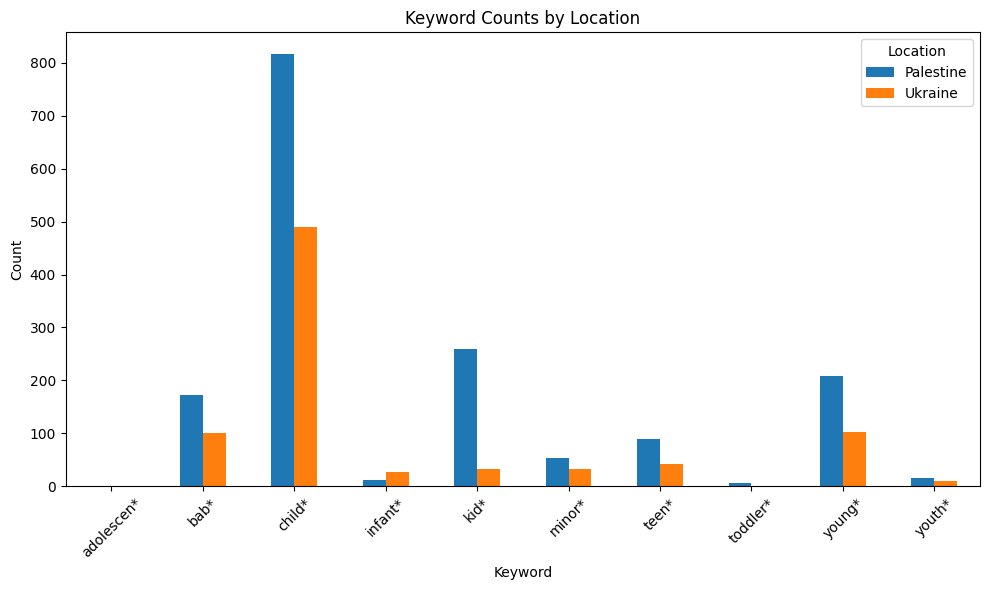

In [69]:
import pandas as pd

# Combine the counts from each DataFrame into a single DataFrame
combined_df = pd.DataFrame()
for location, df in results_dict.items():
    df['location'] = location  # Add a column for location
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Pivot the combined DataFrame for easier plotting
pivot_df = combined_df.pivot_table(index='keyword', columns='location', values='count', fill_value=0)

import matplotlib.pyplot as plt

# Plot
pivot_df.plot(kind='bar', figsize=(10, 6))

plt.title('Keyword Counts by Location')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Location')

# Show plot
plt.tight_layout()
plt.show()

